<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW2B/HW2B_Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading wine data...
Training time: 2.93 seconds
Test Accuracy: 100.00%
Plotting loss curve...


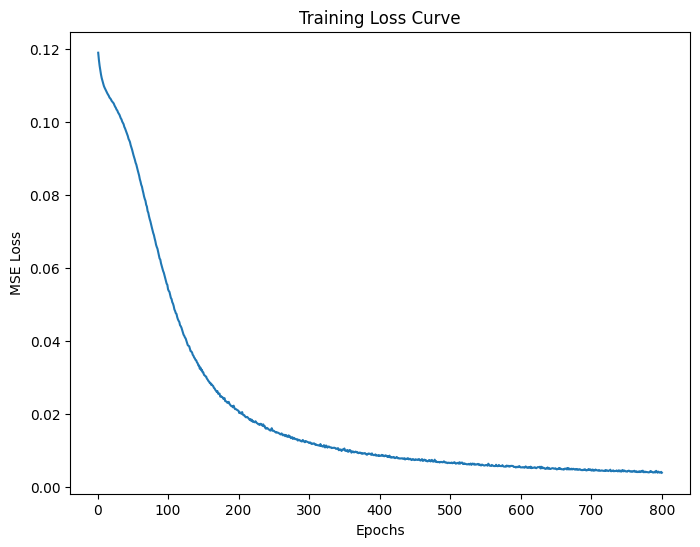

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time

class WineClassifierNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 0.1):
        self.learning_rate = learning_rate

        # initialize weights and bias
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.1
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.1
        self.bias2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def one_hot_encode(self, y, num_classes):
        n = len(y)
        encoded = np.zeros((n, num_classes))
        encoded[np.arange(n), y.astype(int)] = 1
        return encoded

    def forward_pass(self, X):
        """
        Apply forward pass to the neural network.
        Returns: final output and intermediate values.
        """
        self.hidden_input = X @ self.weights1 + self.bias1
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.output_input = self.hidden_output @ self.weights2 + self.bias2
        self.final_output = self.sigmoid(self.output_input)

        return self.final_output

    def backward_pass(self, X, y_true, y_pred):
        n = X.shape[0]

        # Output layer gradients
        output_error = (y_pred - y_true) * self.sigmoid_derivative(self.output_input)
        d_weights2 = self.hidden_output.T @ output_error / n
        d_bias2 = np.sum(output_error, axis=0, keepdims=True) / n

        # Hidden layer gradients
        hidden_error_propagated = output_error @ self.weights2.T
        hidden_error = hidden_error_propagated * self.sigmoid_derivative(self.hidden_input)
        d_weights1 = X.T @ hidden_error / n
        d_bias1 = np.sum(hidden_error, axis=0, keepdims=True) / n

        return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self, gradients):
        d_weights1, d_bias1, d_weights2, d_bias2 = gradients

        self.weights1 -= self.learning_rate * d_weights1
        self.bias1 -= self.learning_rate * d_bias1
        self.weights2 -= self.learning_rate * d_weights2
        self.bias2 -= self.learning_rate * d_bias2

    def train(self, X, y, epochs = 1000, batch_size = 32):
        n_samples = X.shape[0]
        y_one_hot = self.one_hot_encode(y, 3)
        if batch_size > n_samples:
            batch_size = n_samples

        loss_history = []
        start_time = time.time()

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y_one_hot[indices]

            epoch_loss = 0
            n_batches = 0

            for i in range(0, n_samples, batch_size):
                batch_start = i
                batch_end = min(i + batch_size, n_samples)
                X_batch = X_shuffled[batch_start:batch_end]
                y_batch = y_shuffled[batch_start:batch_end]

                # Forward pass
                y_pred = self.forward_pass(X_batch)

                # Calculate loss
                batch_loss = np.mean((y_pred - y_batch) ** 2) / 2
                epoch_loss += batch_loss
                n_batches += 1

                # Backward pass
                gradients = self.backward_pass(X_batch, y_batch, y_pred)

                # Update weights
                self.update_weights(gradients)

            epoch_loss /= n_batches
            loss_history.append(epoch_loss)

        end_time = time.time()
        self.training_time = end_time - start_time

        return loss_history

    def predict(self, X):
        y_pred = self.forward_pass(X)
        return np.argmax(y_pred, axis=1)

def load_wine_data():
    train_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/train_wine.csv"
    test_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/test_wine.csv"

    # Load data
    train_data = pd.read_csv(train_url, header=None)
    test_data = pd.read_csv(test_url, header=None)

    # Separate features and labels
    X_train = train_data.iloc[:, 1:].values  # Features are columns 1-13
    y_train = train_data.iloc[:, 0].values   # Labels are column 0

    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values

    unique_labels = np.unique(y_train)

    if unique_labels.min() > 0:
        y_train = y_train - 1
        y_test = y_test - 1

    return X_train, y_train, X_test, y_test

def main():
    # load data
    print("Loading wine data...")
    X_train, y_train, X_test, y_test = load_wine_data()

    # Normalize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Set neural network parameters
    hidden_size = 10
    learning_rate = 0.1
    epochs = 800

    # Initialize the neural network
    classifier = WineClassifierNN(input_size=13, hidden_size=hidden_size, output_size=3, learning_rate=learning_rate)

    # Train the neural network
    loss_history = classifier.train(X_train, y_train, epochs = epochs)

    print(f"Training time: {classifier.training_time:.2f} seconds")

    # Evaluate test accuracy
    y_pred_test = classifier.predict(X_test)
    test_accuracy = np.mean(y_pred_test == y_test) * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("Plotting loss curve...")

    # Plot training loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), loss_history)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.show()

if __name__ == "__main__":
    main()